# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
import spacy
from spacymoji import Emoji
from nltk.corpus import stopwords, words
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer as lemmatize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import sys
from pprint import pprint

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

import pyLDAvis.gensim


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

In [2]:
df = pd.read_csv('../data/cleaned_reviews.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,neg_score,neu_score,pos_score,compound_score
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,came early good,good,order product,come,NaN,0.0,0.707,0.293,0.4404
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,0.0,0.408,0.592,0.4404
2,5,2020-09-16 20:13:05,shoppee,google,Gd...........,NaN,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000
3,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy,first happy,purchase experience purchase,NaN,NaN,0.0,0.714,0.286,0.3400
4,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot good deal,good,lot item deal,NaN,NaN,0.0,0.715,0.285,0.4927


In [4]:
#list comprehension for target variable
df['rate'] = [1  if (df['rating'][i] > 3) else 0 for i in range(len(df['rating']))]

In [5]:
df['rate'].value_counts(normalize = True)

1    0.799643
0    0.200357
Name: rate, dtype: float64

In [6]:
#Checking null values
df.isna().sum()

rating                0
date                  0
app                   0
store                 0
review                5
clean_content      4773
adj               18158
noun              25522
verb              35821
emoji             73156
neg_score             0
neu_score             0
pos_score             0
compound_score        0
rate                  0
dtype: int64

In [7]:
## Removing null values
df= df[df['clean_content'].notna()]
df.reset_index(drop = True, inplace = True)
print(f'Null values left in df: {df.clean_content.isna().sum()}')
print(f'Number of rows left: {df.shape[0]}')

Null values left in df: 0
Number of rows left: 74161


## Train Test Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['rate'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['rate'])

In [9]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 59328, X_test rows: 14833
y_train rows: 59328, y_test rows: 14833


## Baseline Model

In [10]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(59328, 5000)
(14833, 5000)


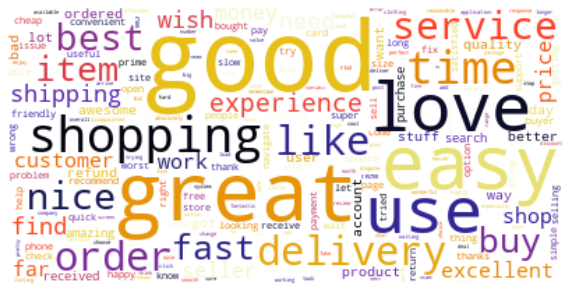

In [11]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.9269990560949298
Accuracy score for Test data set: 0.9102002292186341


In [13]:
preds = lr.predict(test_data_features)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print(f'Specificity: {round(tn / (tn + fp),4)}')
print(f'Sensitivity: {round(tp / (tp + fn),4)}')
print(f'MCC Score: {matthews_corrcoef(y_test,preds)}')

Specificity: 0.6858
Sensitivity: 0.9673
MCC Score: 0.7073892952931293


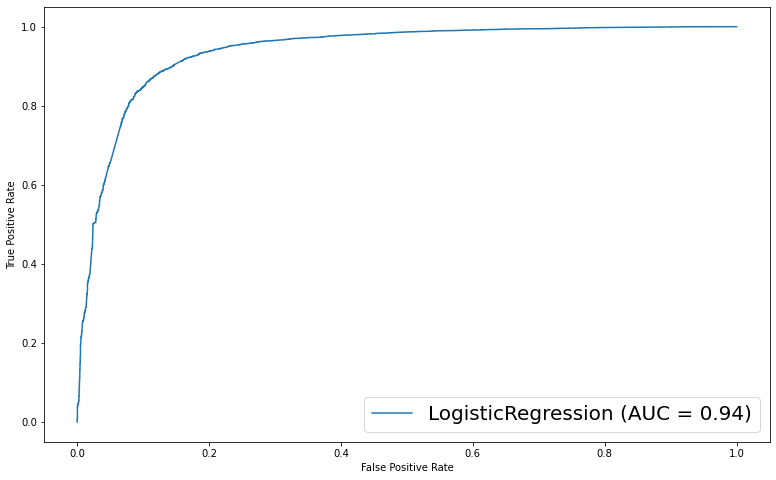

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(lr, test_data_features, y_test, ax = ax)
plt.legend(prop={"size":20});

## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [15]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [7000, 8000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = GridSearchCV(cvec_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  4.9min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.3, max_features=7000, min_df=2,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  296.175s


### TFIDVectorizer Logistic Regression

In [16]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  4.4min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=3,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  263.659s


### HashingVectorizer Logistic Regression

In [17]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [6000, 7000],
    'hash__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = GridSearchCV(hash_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=7000)),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  69.382s


In [18]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,CountVectorizer,0.937742,0.938051,0.706686,296
1,LogisticRegression,TFIDVectorizer,0.945399,0.944906,0.722528,264
2,LogisticRegression,HashingVectorizer,0.943851,0.943325,0.712263,69


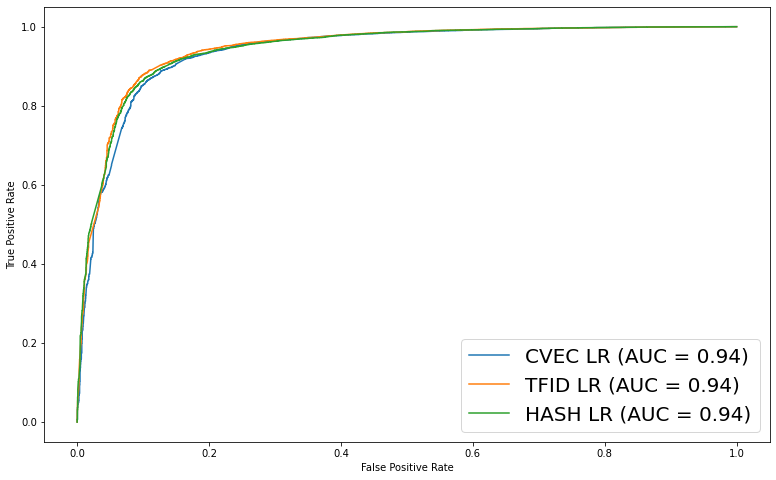

In [19]:
fig, ax = plt.subplots(figsize=(13, 8))
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, X_test, y_test, name = 'CVEC LR', ax = ax)
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFID LR', ax = ax)
hash_lr_disp = plot_roc_curve(gs_hash_lr, X_test, y_test, name = 'HASH LR', ax = ax)
plt.legend(prop={"size":20});

In [20]:
print('Best Vectorizer Classification Report')
pd.DataFrame(classification_report(y_test, 
                            gs_tfid_lr.predict(X_test),
                            target_names = ['Bad_Reviews', 'Good_reviews'], 
                            output_dict=True)).T

Best Vectorizer Classification Report


,precision,recall,f1-score,support
Bad_Reviews,0.826843,0.726337,0.773338,3011.000000
Good_reviews,0.932393,0.961259,0.946606,11822.000000
accuracy,0.913571,0.913571,0.913571,0.913571
macro avg,0.879618,0.843798,0.859972,14833.000000
weighted avg,0.910967,0.913571,0.911433,14833.000000


## Modeling

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.sparse import reorder
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\Sim Yi\anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py:546: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class IteratorBase(collections.Iterator, trackable.Trackable,
C:\Users\Sim Yi\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:106: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class DatasetV2(collections.Iterable, tracking_base.Trackable,


In [19]:
def nn_model(optimizer='adam', dropout=0.5, init='uniform', dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', kernel_initializer=init,)) 
    model.add(Dropout(dropout), )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

class ArrayTransformer():
    
    def transform(self, X, **transform_params):
        return X.toarray()
    
    def fit(self, X, y=None, **fit_params):
        return self
    
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0, 
                           patience = 3, 
                           mode = 'auto')


In [20]:
# Setting pipeline for two stages
tfid_nn = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('array', ArrayTransformer()),
    ('nn', KerasClassifier(build_fn = nn_model, verbose=1))
])

pipe_params = {
    'tfid__max_features': [8000],
    'tfid__min_df': [3],
    'tfid__max_df': [.3],
    'nn__epochs': [10],
    'nn__dense_nparams': [8]
}
    

gs_tfid_nn = GridSearchCV(tfid_nn, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.


gs_tfid_nn.fit(X_train, y_train, nn__validation_split = 0.2, nn__callbacks=[early_stop])



print(f'Best Parameters: {gs_tfid_nn.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.3s finished


Epoch 1/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.3734 - accuracy: 0.8499 - val_loss: 0.2416 - val_accuracy: 0.9122
Epoch 2/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.2687 - accuracy: 0.8953 - val_loss: 0.2221 - val_accuracy: 0.9168
Epoch 3/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.2522 - accuracy: 0.9022 - val_loss: 0.2175 - val_accuracy: 0.9172
Epoch 4/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.2423 - accuracy: 0.9057 - val_loss: 0.2166 - val_accuracy: 0.9184
Epoch 5/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.2361 - accuracy: 0.9103 - val_loss: 0.2168 - val_accuracy: 0.9167
Epoch 6/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.2311 - accuracy: 0.9112 - val_loss: 0.2181 - val_accuracy: 0.9167
Epoch 7/10
1484/1484 [==============================] - 2s 1ms/step - loss: 0.2283 - accuracy: 0.9118 - val_loss: 0.2204 - val_accuracy:

In [21]:
print(f'{gs_tfid_nn.score(X_test, y_test)}')

Instructions for updating:
Please use `model.predict()` instead.
464/464 [==============================] - 0s 509us/step
0.9454248171748983


In [22]:
print(f'{matthews_corrcoef(y_test, gs_tfid_nn.predict(X_test))}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
464/464 [==============================] - 0s 504us/step
0.7241820978850285


In [ ]:
#import pickle
#filename = 'finalized_model.pkl'
#pickle.dump(model, open(filename, 'wb'))